In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision.transforms import v2
import os
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as psnr
import torchvision.transforms as transforms

#### Load files

Loaded 1 images
Loaded target image
Created noisy image with noise std=95


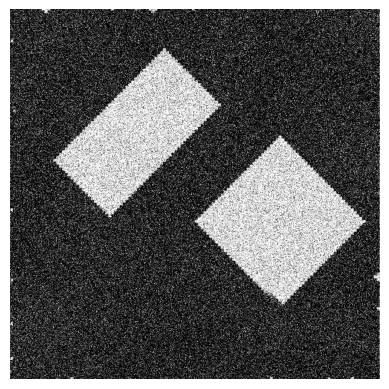

In [2]:
image_dir = 'priors'
grayscale = torchvision.transforms.Grayscale()
img_shape = (640, 640)
# Read all images
images = torch.zeros((0, *img_shape))
reshape = v2.Resize(img_shape)
for filename in os.listdir(image_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        img_path = os.path.join(image_dir, filename)
        img = torchvision.io.decode_image(img_path, torchvision.io.ImageReadMode.GRAY)
        img = reshape(img)
        images = torch.concat([images, img])

print(f"Loaded {len(images)} images")
images = images[None,:]
images.shape


# img_path = os.path.join("noisy", 'rects.png')
# noisy = torchvision.io.decode_image(img_path, torchvision.io.ImageReadMode.GRAY)
# noisy = reshape(noisy)
# print(f"Loaded noisy image")

img_path = os.path.join("true", 'rects.png')
target = torchvision.io.decode_image(img_path, torchvision.io.ImageReadMode.GRAY)
target = reshape(target)
print(f"Loaded target image")
# Create noisy version of target image
noise_std = 95
noise = torch.randn_like(target, dtype=torch.float32) * noise_std
noisy = torch.clamp(target.float() + noise, 0, 255).to(torch.float64)
print(f"Created noisy image with noise std={noise_std}")

# import matplotlib.pyplot as plt


plt.imshow(noisy.squeeze(), cmap='gray')
plt.axis('off')
plt.show()

#### Extract Prior Patches

In [ ]:
patch_shape = (8, 8)

def patch_extractor(x: torch.Tensor, patch_shape: tuple[int, int], batch: bool = True):
    '''
    input:
        - x: image of shape. (C, H, W) if batch=False; (N, C, H, W) if batch=True
        - patch_shape: the shape of the patch (P_H, P_W)
        - batch: whether the given tensor is a single image or a batch of images
    returns:
        - patch: Patches of shape (Patches, P_H, P_W) or (N, Patches, P_H, P_W) if batch=False
    '''
    patch_extr = torch.nn.Unfold(patch_shape)
    if not batch:
        x = torch.clone(x)[None, :]
        # print("New x shape:", x.shape)
    patch = patch_extr(x)
    patch = torch.swapaxes(patch, -1, -2)
    patch = patch.reshape((*patch.shape[:-1], *patch_shape))
    # print("Patches shape:", patch.shape)
    return patch if batch else patch[0]

# Patches now have shape (N, Num of Patches, Patch_Size, Patch_Size)

patch = patch_extractor(images, patch_shape)
# Create a grid to display all patches
num_patches = 49
grid_size = int(np.ceil(np.sqrt(num_patches)))

fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
axes = axes.flatten()

for i in range(num_patches):
    axes[i].imshow(patch[0, i+100800].numpy(), cmap='gray', vmin=0, vmax=255)
    axes[i].axis('off')

# Hide any unused subplots
for i in range(num_patches, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

#### GMM - Patch Prior

In [4]:
gmm = GMM(200).fit(
    (
        patch.reshape(-1, patch_shape[0]*patch_shape[1])
    ).numpy().astype(np.float64)) # GMM accepts shape (N, Features)

In [5]:
torch.save(gmm, "priors200.pt")
# gmm = torch.load("priors.pt", weights_only=False)

In [ ]:
num_patches = 40
grid_size = int(np.ceil(np.sqrt(num_patches)))

fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
axes = axes.flatten()
for i in range(num_patches):
    axes[i].imshow(np.array(gmm.means_)[i].reshape(patch_shape), cmap='gray', vmin=0, vmax=255)
    axes[i].axis('off')

# Hide any unused subplots
for i in range(num_patches, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

#### Optimisation with auto-diff

In [ ]:
beta = 1.0
lr = 5.0

weights = torch.from_numpy(gmm.weights_).to(torch.float64)
means = torch.from_numpy(gmm.means_).to(torch.float64)
sigmas = torch.from_numpy(gmm.precisions_).to(torch.float64)
def EPLLloss(x: torch.Tensor):
    '''
    Computes EPLL loss given some image x (1, H, W)
    and the prior distribution (assume GMM)
    '''
    patches = patch_extractor(x, patch_shape, batch=False) # (Patches, P_H, P_W)
    patches_flat = patches.reshape(-1, patch_shape[0]*patch_shape[1])
    
    N_components = means.shape[0]
    
    # Compute log probabilities for all components (numerically stable)
    log_probs = torch.zeros((patches_flat.shape[0], N_components), dtype=torch.float64)
    
    for k in range(N_components):
        nd_gaussian = torch.distributions.multivariate_normal.MultivariateNormal(means[k], precision_matrix=sigmas[k])
        log_probs[:, k] = torch.log(weights[k]) + nd_gaussian.log_prob(patches_flat)
    
    # Use log-sum-exp trick for numerical stability
    log_likelihood = torch.logsumexp(log_probs, dim=1)
    
    return torch.sum(log_likelihood)

# x = torch.rand((1, *img_shape), requires_grad=True)
print(noisy.shape)
x = noisy.to(torch.float64).clone()
x.requires_grad=True

opt = torch.optim.Adam([x], lr=lr)  # Reduced learning rate for stability

for i in tqdm(range(20)):
    opt.zero_grad()
    l1 = EPLLloss(x)
    og_closeness = torch.sum(torch.pow(x - noisy.to(torch.float64), 2))

    loss = og_closeness - beta*l1  # Balance the two terms with a weight
    loss.backward()
    opt.step()
    if (i % 2)==0:
        plt.imshow(x.detach().numpy().squeeze().clip(0, 255), cmap='gray')
        plt.show()
        # print("PSNR:", psnr(x))
        print(loss.item())
    
    # Clamp x to valid pixel range to prevent divergence
    with torch.no_grad():
        x.clamp_(0, 255)


#### Optimisation with half-quadratic split with auto-diff

In [ ]:
l = 1.0
b = 25.0

lr = 5.0

weights = torch.from_numpy(gmm.weights_).to(torch.float64)
means = torch.from_numpy(gmm.means_).to(torch.float64)
sigmas = torch.from_numpy(gmm.precisions_).to(torch.float64)
def EPLLloss(x: torch.Tensor):
    '''
    Computes EPLL loss given some image x (1, H, W)
    and the prior distribution (assume GMM)
    '''
    patches = patch_extractor(x, patch_shape, batch=False) # (Patches, P_H, P_W)
    patches_flat = patches.reshape(-1, patch_shape[0]*patch_shape[1])
    
    N_components = means.shape[0]
    
    # Compute log probabilities for all components (numerically stable)
    log_probs = torch.zeros((patches_flat.shape[0], N_components), dtype=torch.float64)
    
    for k in range(N_components):
        nd_gaussian = torch.distributions.multivariate_normal.MultivariateNormal(means[k], precision_matrix=sigmas[k])
        log_probs[:, k] = torch.log(weights[k]) + nd_gaussian.log_prob(patches_flat)
    
    # Use log-sum-exp trick for numerical stability
    log_likelihood = torch.logsumexp(log_probs, dim=1)
    
    return torch.sum(log_likelihood)

# x = torch.rand((1, *img_shape), requires_grad=True)
print(noisy.shape)
x = noisy.to(torch.float64).clone()
z = noisy.to(torch.float64).clone()
x.requires_grad=True
z.requires_grad = True

opt = torch.optim.Adam([x, z], lr=lr)  # Reduced learning rate for stability

for i in tqdm(range(20)):
    opt.zero_grad()
    l1 = EPLLloss(z)
    
    x_patch = patch_extractor(x, patch_shape, batch=False) # (Patches, P_H, P_W)
    z_patch = patch_extractor(z, patch_shape, batch=False) # (Patches, P_H, P_W)
    
    og_closeness = (l/2.0) * torch.sum(torch.pow(x - noisy.to(torch.float64), 2))\
        + (b/2.0)*torch.sum(torch.pow(x_patch - z_patch, 2))

    loss = og_closeness - l1  # Balance the two terms with a weight
    loss.backward()
    opt.step()
    if (i % 2)==0:
        plt.imshow(x.detach().numpy().squeeze().clip(0, 255), cmap='gray')
        plt.show()
        print("PSNR:", psnr(target.numpy(), x.detach().numpy()))
        print(loss.item())
    
    # Clamp x to valid pixel range to prevent divergence
    with torch.no_grad():
        x.clamp_(0, 255)
        z.clamp(0, 255)



/var/folders/ms/lvhkg1ns0z1bhb39n9bmf2s40000gn/T/ipykernel_26895/2246151482.py:12: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  axes[2].set_title(f'Restored Image (PSNR: {psnr(target.numpy(), x.detach().numpy()):.2f} dB)')


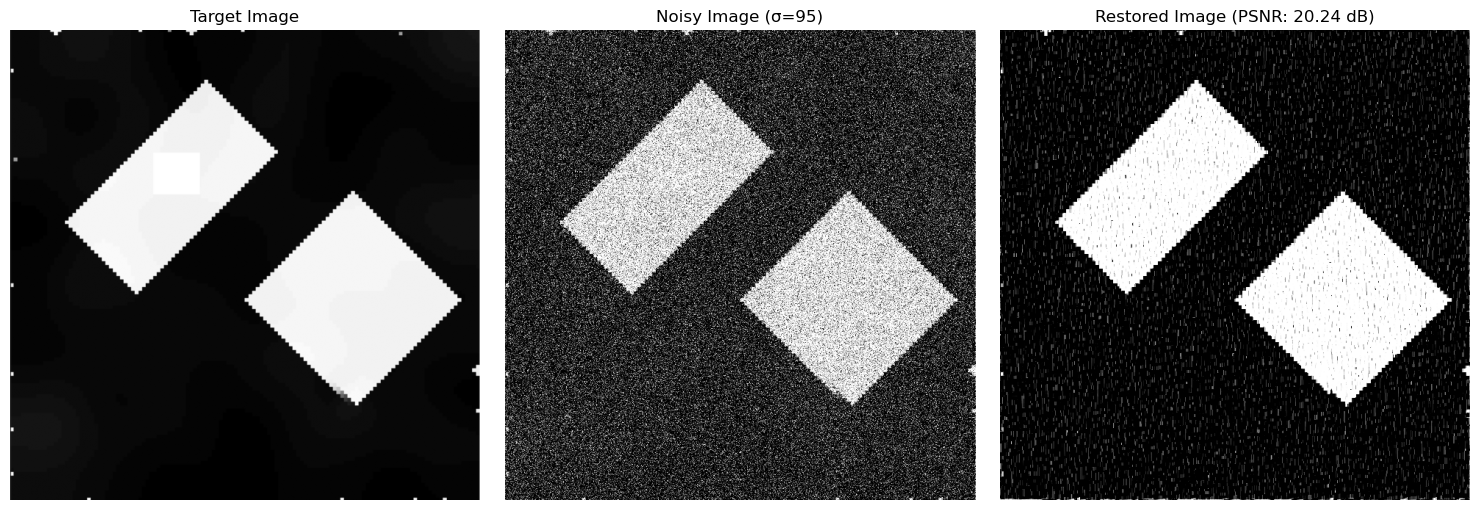

In [77]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(target.squeeze().numpy(), cmap='gray', vmin=0, vmax=255)
axes[0].set_title('Target Image')
axes[0].axis('off')

axes[1].imshow(noisy.squeeze().numpy(), cmap='gray', vmin=0, vmax=255)
axes[1].set_title(f'Noisy Image (σ={noise_std})')
axes[1].axis('off')

axes[2].imshow(x.detach().squeeze().numpy().clip(0, 255), cmap='gray', vmin=0, vmax=255)
axes[2].set_title(f'Restored Image (PSNR: {psnr(target.numpy(), x.detach().numpy()):.2f} dB)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

#### HQS

In [ ]:
lamb = 100.0 / (noise_std**2)
betas = torch.tensor([2, 8, 16, 32, 64], dtype=torch.float64) * lamb
iters = 3

weights = torch.from_numpy(gmm.weights_).to(torch.float64)
means = torch.from_numpy(gmm.means_).to(torch.float64)
sigmas = torch.from_numpy(gmm.covariances_).to(torch.float64)

# x = torch.rand((1, *img_shape), requires_grad=True)
print(noisy.shape)
x = noisy.to(torch.float64).clone()
z_patch = patch_extractor(x, patch_shape, batch=False) # (Patches, P_H, P_W)
x.requires_grad=False


pbar = tqdm(total=len(betas)*iters)
fold = torch.nn.Fold(output_size= img_shape, kernel_size=patch_shape)
unfold = torch.nn.Unfold(patch_shape)

patch_cshape = patch_shape[0]*patch_shape[1]

print("INIT:")
print("PSNR:", psnr(target.numpy(), x.numpy()))
plt.imshow(x.numpy().squeeze().clip(0, 255), cmap='gray')
plt.show()

input_ones = torch.ones(size = (1, 1, *img_shape))
divisor = fold(unfold(input_ones)).squeeze()
for b in betas:
    for i in range(iters):
        
        # Update z
        x_patch = patch_extractor(x, patch_shape, batch=False) # (Patches, P_H, P_W)
        k_max = gmm.predict(x_patch.reshape(-1, patch_shape[0]*patch_shape[1]).numpy())
        kmax = torch.from_numpy(k_max)
        
        z_patch = torch.matmul((sigmas[k_max] + (1.0/b)*torch.eye(patch_cshape)).inverse(), (torch.matmul(sigmas[k_max], x_patch.reshape(-1, patch_cshape, 1))+(1.0/b)*means[k_max][:,:, None]))
        
        # Update x
        z_folder = fold(z_patch.reshape(-1, patch_cshape).swapaxes(0,1))
        
        x = (lamb*noisy + b*z_folder) / (lamb + b*divisor)
        
        print("PSNR:", psnr(target.numpy(), x.numpy()))
        print("X:")
        plt.imshow(x.numpy().squeeze().clip(0, 255), cmap='gray')
        plt.show()
        print("Z:")
        plt.imshow((z_folder / divisor).squeeze().numpy().squeeze().clip(0, 255), cmap='gray')
        plt.show()
        pbar.update(1)



/var/folders/ms/lvhkg1ns0z1bhb39n9bmf2s40000gn/T/ipykernel_39762/413265430.py:12: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  axes[2].set_title(f'Restored Image (PSNR: {psnr(target.numpy(), x.numpy()):.2f} dB)')


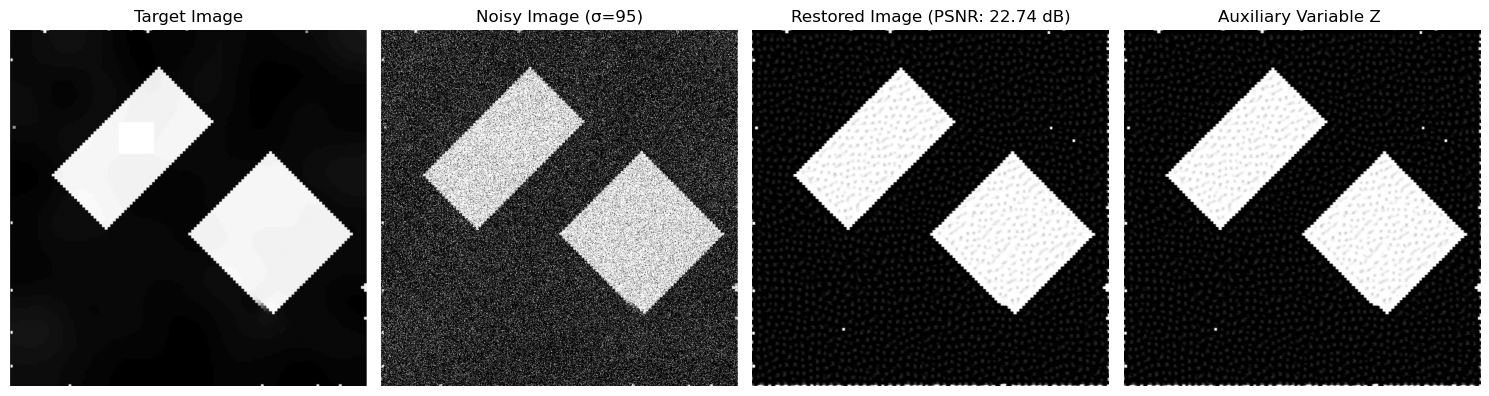

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

axes[0].imshow(target.squeeze().numpy(), cmap='gray', vmin=0, vmax=255)
axes[0].set_title('Target Image')
axes[0].axis('off')

axes[1].imshow(noisy.squeeze().numpy(), cmap='gray', vmin=0, vmax=255)
axes[1].set_title(f'Noisy Image (σ={noise_std})')
axes[1].axis('off')

axes[2].imshow(x.squeeze().numpy().clip(0, 255), cmap='gray', vmin=0, vmax=255)
axes[2].set_title(f'Restored Image (PSNR: {psnr(target.numpy(), x.numpy()):.2f} dB)')
axes[2].axis('off')

axes[3].imshow((z_folder / divisor).squeeze().numpy().clip(0, 255), cmap='gray', vmin=0, vmax=255)
axes[3].set_title(f'Auxiliary Variable Z ')
axes[3].axis('off')

plt.tight_layout()
plt.show()

In [17]:
x.shape

torch.Size([1, 640, 640])

In [108]:
z_patch = patch_extractor(x, patch_shape, batch=False) # (Patches, P_H, P_W)
print(z_patch.shape)

torch.Size([403225, 6, 6])


In [17]:
means[:,:, None].shape

torch.Size([40, 36, 1])